In [ ]:
#| default_exp models

In [ ]:
#| export
import fastai
from copy import deepcopy
from fastcore.all import *
from fastai.vision.all import *

from step.data import DEFAULT_TOKEN

## Utility layers

In [ ]:
#| export
def get_act(vocab_sz, yrange=(0, 2.05)):
    "Provides activation according to regression or classification task."
    if vocab_sz == 1:
        act = SigmoidRange(*yrange)
    else:
        act = nn.Softmax(dim=-1)
    return act

def _get_acts(n_class, yrange=(0, 2.05)):
    act = SigmoidRange(*yrange) if n_class == 1 else noop
    activation = nn.Softmax(dim=-1) if n_class > 1 else noop
    return act, activation
    
class Normalization(Module):
    "Z-Normalization over the designated dimension."
    def __init__(self, dim=-1): self.dim = dim
    def forward(self, x): 
        return (x - x.mean(self.dim).unsqueeze(self.dim))/x.std(self.dim).unsqueeze(self.dim)
    
class Transpose(Module):
    "Transposition layer of dims."
    def __init__(self, dims): self.dims = dims
    def forward(self, x): return x.transpose(*self.dims)
    
def tfm_encoder(dim, n_head=1, n_layers=8, dim_ff=1024, dropout=0.1, activation='relu'):
    "Creates a `nn.TransformerEncoder`."
    encoder_layer = nn.TransformerEncoderLayer(dim, n_head, dim_ff, dropout, activation)
    encoder_norm = nn.LayerNorm(dim)
    return nn.TransformerEncoder(encoder_layer, n_layers, encoder_norm)  

## Classifier

In [ ]:
#| export
class Classifier(Module):
    "Dense classifier"
    def __init__(self, dims, ps, final_act=False, yrange=None, trp=(2, 1)):
        if len(ps) != len(dims)-1: 
            raise ValueError(f"Number of layers {len(dims)} and dropout values {len(ps)} don't match.")
        acts = [nn.ReLU(inplace=True)] * (len(dims) - 2) + [None]
        layers = [LinBnDropTrp(i, o, p=p, act=a, trp=trp) for i,o,p,a in zip(dims[:-1], dims[1:], ps, acts)]
        if final_act: layers.append(get_act(dims[-1], yrange=yrange))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): return self.layers(x)
    
class LinBnDropTrp(nn.Sequential):
    def __init__(self, n_in, n_out, bn=True, p=0., trp=(2, 1), act=None, ndim=1):
        layers = [BatchNorm(n_in, ndim=ndim)] if bn else []
        if p!=0.: layers.append(nn.Dropout(p))
        if trp: layers = [Transpose(trp)] + layers + [Transpose(trp)]
        layers.append(nn.Linear(n_in, n_out, bias=not bn))
        if act is not None: layers.append(act)
        super().__init__(*layers)

class ConcatPooling(Module):
    "Perform max and average pool over `dim`. Outputs [avg_pool, max_pool]."
    def __init__(self, dim=-1): self.dim = dim
    def forward(self, x): return torch.cat([x.mean(dim=self.dim), x.max(dim=self.dim)[0]], dim=1)

## Transformer

### Full transformer

In [ ]:
#| export
class Transformer(nn.Module):
    def __init__(self, dim, n_class=5, nhead_enc=1, nhead_dec=1, num_encoder_layers=6, 
                 num_decoder_layers=6, dim_ff=2048, dropout=0.1, activation='relu'):
        super(Transformer, self).__init__()
        store_attr('dim,n_class')
        encoder_layer = nn.TransformerEncoderLayer(dim, nhead_enc, dim_ff, dropout, activation)
        encoder_norm = nn.LayerNorm(dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)
        self.linear_enc_dec = nn.Linear(dim, n_class)
        
        decoder_layer = nn.TransformerDecoderLayer(n_class, nhead_dec, dim_ff, dropout, activation)
        decoder_norm = nn.LayerNorm(n_class)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)
        self.memory_norm = deepcopy(decoder_norm)
        
        self.generator = nn.Linear(n_class, n_class)
        self.activation = nn.Softmax(dim=-1)
        
        self._reset_parameters()
        
    def forward(self, src, tgt, use_mask=True, src_mask=None, tgt_mask=None, memory_mask=None, 
                src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        "`src` is the input to predict `tgt`."
        src, tgt = [x.transpose(1, 0) for x in (src, tgt)]
        if use_mask and tgt_mask is None: tgt_mask = self.get_square_subsequent_mask(tgt.shape[0])
        memory = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        memory = self.memory_norm(self.linear_enc_dec(memory)) # Our cheecky lil' trick
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        return self.generator(output).transpose(1, 0)
    
    def segment(self, x, n_class=5, y=None, length=None):
        "Segmentation of input `x` without target reference."
        x = self._check_rank(x)
        if length is None: bs, length, _ = x.shape
        else:              bs = x.shape[0]
        y = DEFAULT_TOKEN * torch.ones(bs, 1, self.n_class).type_as(x) if y is None else y
        outs, preds = [], []
        # Check preds shapes to stack them afterwards
        for _ in range(length):
            out = self.forward(x, y, use_mask=False)[:, -1].unsqueeze(1)
            prob = self.activation(out)
            pred = prob.argmax(-1)
            next_y = torch.zeros(bs, n_class, device=x.device
                                ).scatter_(-1, pred, 1).unsqueeze(1)
            y = torch.cat([y, next_y], dim=1)
            preds.append(pred); outs.append(out)
        return torch.cat(preds, dim=1), y[:, 1:], torch.cat(outs, dim=1)
        
    def get_square_subsequent_mask(self, sz):
        r"""Generate a square mask for the sequence. Masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0)."""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == False, float('-inf')).masked_fill(mask, float(0.))
        return mask.to(default_device())
    
    def _check_rank(self, x):
        "Checks that input rank is correct."
        rank = len(x.shape)
        if   rank == 1: return x.unsqueeze(0).unsqueeze(-1)
        elif rank == 2: return x.unsqueeze(0)
        elif rank == 3: return x
        else: raise ValueError(f"Input should be rank 1, 2 or 3 tensor. Got rank {rank}.")
         
    def _reset_parameters(self):
        "Initiate parameters in the transformer model."
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

In [ ]:
#| include: false
from step.data import get_transformer_dls

In [ ]:
tfm_dls = get_transformer_dls(bs=128)

In [ ]:
my_tf = Transformer(1, num_encoder_layers=4, num_decoder_layers=4, dim_ff=500)
my_tf.to(default_device())
learn = Learner(tfm_dls, my_tf, loss_func=CrossEntropyLossFlat(), model_dir='../models')

In [ ]:
learn.fit_one_cycle(15, lr_max=1e-2)

epoch,train_loss,valid_loss,time
0,0.081026,0.063063,00:41
1,0.047181,0.045920,00:40
2,0.044656,0.043783,00:41
3,0.043903,0.043491,00:40
4,0.043756,0.043521,00:41
5,0.043616,0.043354,00:41
6,0.043514,0.043158,00:40
7,0.043429,0.043019,00:41
8,0.043339,0.043081,00:41
9,0.043207,0.042961,00:41


In [ ]:
learn.load('test0')

<fastai.learner.Learner>

In [ ]:
x, y_one_hot, y = dls.one_batch()

In [ ]:
learn.model.eval()
with torch.no_grad():
    preds, pred_one_hot, outs = learn.model.segment(x)

In [ ]:
preds[:10, :10]

tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]], device='cuda:0')

In [ ]:
y[:10, :10]

tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]], device='cuda:0')

### Positional encoding

Transformers see the trajectories all at once and, therefore, they have no notion of distance between the points. In order to characterize the diffusion process of every point, we need not only to extract local information about it, but also to provide a notion of context. 

Here, we implement a positional encoding based on the addition of sines and cosines to the data, as introduced in [this paper](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

In [ ]:
#| export
class PositionalEncoding(Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        r"Positional encoding of the form $sin(\omega_k t), cos(\omega_k t)$ with $\omega_k=\frac{1}{10000^{2k/d}} for even `d_model`."
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        omega = 1/(10000**(torch.arange(0, d_model, 2)/d_model)) # d_model must be even
        pos_enc = torch.zeros(max_len, 1, d_model)
        pos_enc[:, 0, 0::2] = torch.sin(omega*position)
        pos_enc[:, 0, 1::2] = torch.cos(omega*position)
#         self.pos_enc = pos_enc
        self.register_buffer('pos_enc', pos_enc)

    def forward(self, x):
        "Adds positional encoding to input `x` with shape [length, batch_size, d_model]."
        x = x + self.pos_enc[:x.size(0)]
        return self.dropout(x)

In [ ]:
pe = PositionalEncoding(14, max_len=100)
pos_enc = pe.pos_enc.squeeze()

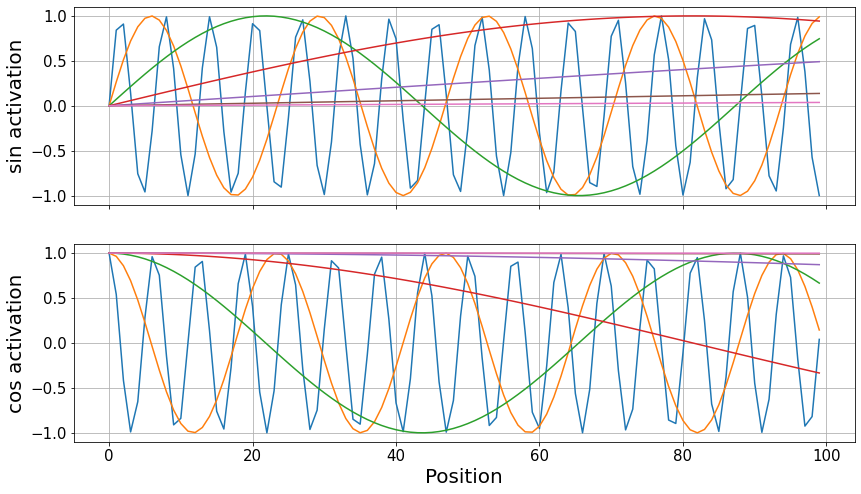

In [ ]:
#| code-fold: true
fontsize, ticksize = 20, 15
fig, axes = plt.subplots(2, sharex=True, figsize=(14, 8))
for sin, cos in zip(pos_enc.T[::2], pos_enc.T[1::2]):
    axes[0].plot(sin)
    axes[1].plot(cos)

axes[1].set_xlabel("Position", fontsize=fontsize)
axes[0].set_ylabel("sin activation", fontsize=fontsize)
axes[1].set_ylabel("cos activation", fontsize=fontsize)
for ax in axes:
    ax.grid()
    ax.tick_params(labelsize=ticksize)

### Encoder

In [ ]:
#| export
class EncoderClassifier(Module):
    def __init__(self, dim, length=200, n_class=5, nhead_enc=1, num_encoder_layers=6, dim_ff=2048, 
                 dropout=0.1, activation='relu', linear_layers=[1024], ps=None, final_act=False):
        super(EncoderClassifier, self).__init__()
        store_attr('dim,n_class')
        self.norm = self.norm = Normalization(1)
        encoder_layer = nn.TransformerEncoderLayer(dim, nhead_enc, dim_ff, dropout, activation)
        encoder_norm = nn.LayerNorm(dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)
#         self.concat_pool = ConcatPooling()
#         lin_dim = [2*length] + linear_layers + [n_class]
#         if ps is None: ps = [dropout]*(len(linear_layers)+1)
#         self.linear = Classifier(lin_dim, ps, final_act=final_act
        self.linear = nn.Linear(1, 5)
        self.activation = nn.Softmax(dim=-1)
        
        self._reset_parameters()
        
    def forward(self, x, use_mask=False, src_mask=None, src_key_padding_mask=None):
        "to ease the integration with fastai."
        src = x.transpose(1, 0)
        if use_mask and src_mask is None: src_mask = self.get_random_mask(src.shape[0])
        out_enc = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
#         pool_out_enc = self.concat_pool(out_enc.transpose(1, 0))
        return self.linear(out_enc.transpose(1, 0))
    
    def get_random_mask(self, sz, pct=0.15):
        "Returns random mask with `pct` probability of dropping every input."
        mask = torch.rand(sz, sz) >= pct
        mask = mask.float().masked_fill(mask == False, float('-inf')).masked_fill(mask, float(0.))
        return mask.to(default_device())
        
    def _reset_parameters(self):
        "Initiate parameters in the transformer model."
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

In [ ]:
#| include: false
from step.data import get_segmentation_dls

In [ ]:
dls = get_segmentation_dls()
dls.device = default_device()

In [ ]:
enc = EncoderClassifier(1, num_encoder_layers=12, dim_ff=1024)
enc.to(default_device())
learn = Learner(dls, enc, loss_func=CrossEntropyLossFlat(), model_dir='../models')

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=6.309573450380412e-07)

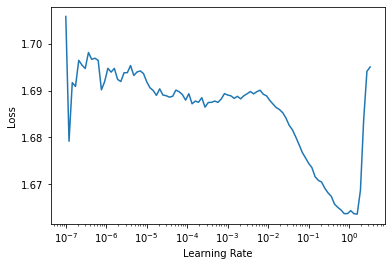

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-1)

epoch,train_loss,valid_loss,time
0,1.611631,1.609615,00:58
1,1.611847,1.613333,00:58
2,1.611033,1.609803,00:59
3,1.609777,1.609575,00:59
4,1.609749,1.609633,01:00


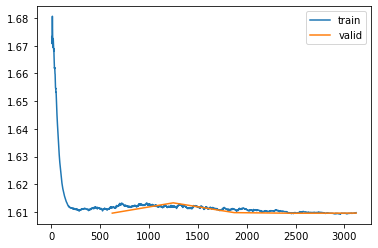

In [ ]:
learn.recorder.plot_loss()

## CNN and Attention

In [ ]:
#| export
class XResBlocks(nn.Sequential):
    @delegates(ResBlock)
    def __init__(self, block, layers, expansion=1, p=0.0, c_in=1, n_out=1000, stem_szs=(32,32,64),
                 block_szs=None, widen=1.0, ndim=1, ks=3, stride=2, sa=False, stem_stride=False,
                 act_cls=defaults.activation, **kwargs):
        store_attr('block,expansion,act_cls,ndim,ks')
        if ks % 2 == 0: raise Exception(f'Kernel size has to be odd! Input ks={ks}.')
        stem_szs = [c_in, *stem_szs]
        stem = [ConvLayer(stem_szs[i], stem_szs[i+1], ks=ks, stride=stride if (i==0 and stem_stride) else 1,
                          act_cls=act_cls, ndim=ndim) for i in range(len(stem_szs)-1)]
        if len(stem) > 1: stem += [MaxPool(ks=ks, stride=stride, padding=ks//2, ndim=ndim)]
        n_layers = len(layers)
#         block_szs = [stem_szs[-1], 128, 256, 512] + [256]*(n_layers-4)
        block_szs = [128, 256, 512] + [256]*(n_layers-4) if block_szs is None else block_szs
        block_szs = [int(o*widen) for o in block_szs[:n_layers]]
        block_szs = [stem_szs[-1]//expansion] + block_szs
        blocks    = self._make_blocks(layers, block_szs, sa, stride, **kwargs)
        
        super().__init__(*stem, *blocks)
        init_cnn(self)
        
    def _make_blocks(self, layers, block_szs, sa, stride, **kwargs):
        return [self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l,
                                 stride=1 if i==0 else stride, sa=sa and i==len(layers)-4, **kwargs)
                for i,l in enumerate(layers)]

    def _make_layer(self, ni, nf, blocks, stride, sa, **kwargs):
        return nn.Sequential(
            *[self.block(self.expansion, ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                      sa=sa and i==(blocks-1), act_cls=self.act_cls, ndim=self.ndim, ks=self.ks, **kwargs)
              for i in range(blocks)])

In [ ]:
max_len = 10
d_model = 5

position = torch.arange(max_length).unsqueeze(1)
position.shape

torch.Size([10, 1])

In [ ]:
div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000) / d_model))

In [ ]:
div_term

tensor([1.0000e+00, 2.5119e-02, 6.3096e-04])

In [ ]:
omega = 1/(10000**(torch.arange(0, d_model, 2)/d_model))
omega

tensor([1.0000e+00, 2.5119e-02, 6.3096e-04])

### CNN + Encoder + FNN

In [ ]:
#| export
class ConvAttn(Module):
    "Convolution layers with attention at the end."
    def __init__(self, dim, n_class=5, conv_dims=[64, 128, 128], nhead_enc=1, num_encoder_layers=6, 
                 dim_ff=2048, dropout=0.1, linear_layers=[128], activation='relu', yrange=(0, 2.05)):
        store_attr('dim,n_class')
        self.norm = Normalization(1)
        conv_dims = [dim] + conv_dims
        conv_layers = [ConvLayer(ni, nf, ndim=1) for ni, nf in zip(conv_dims[:-1],conv_dims[1:])]
        self.convs = nn.Sequential(*conv_layers)
        self.encoder = tfm_encoder(conv_dims[-1], nhead_enc, num_encoder_layers, dim_ff, dropout, activation)
        linear_layers = [conv_dims[-1]] + linear_layers + [n_class]
        ps = [dropout]*(len(linear_layers)-1)
        self.linear = Classifier(linear_layers, ps, trp=(2, 1))
        # act is called in forward, activation is called in validation functions.
        self.act, self.activation = _get_acts(n_class, yrange)
        
    def forward(self, x, use_mask=False, src_mask=None, src_key_padding_mask=None):
        x = self.norm(x)
        x = self.convs(x.transpose(2, 1)).transpose(2, 1)
        src = x.transpose(1, 0)
        if use_mask and src_mask is None: src_mask = self.get_random_mask(src.shape[0])
        out_enc = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        return self.act(self.linear(out_enc.transpose(1, 0)))
    
    def _reset_parameters(self):
        "Initiate parameters in the transformer model."
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)  

In [ ]:
#| include: false
from step.data import get_segmentation_dls
from step.utils import post_process_prediction

Performing a diffusion model segmentation task is the most straightforward, simply specify the trajectory dimension, which defaults to `dim=1` in the dataloaders and provide the appropiate loss function `CrossEntropyLossFlat`. 

In [ ]:
dls = get_segmentation_dls()
dls.device = default_device()

In [ ]:
model = ConvAttn(2, conv_dims=[64, 128, 128], num_encoder_layers=8, dim_ff=512, nhead_enc=8, linear_layers=[])
model.to(default_device())
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), model_dir='../models')

For anomalous exponent segmentation, we must specify the target `target='y_exp'` as well as provide the corresponding loss function, either `L1LossFlat` or `MSELossFlat`. Don't forget to provide the model with the proper number of classes `n_class=1`.

In [ ]:
dls = get_segmentation_dls(dim=1, target='y_exp')
dls.device = default_device()

In [ ]:
model = ConvAttn(1, n_class=1, conv_dims=[32, 64, 128, 256], num_encoder_layers=8, dim_ff=512, nhead_enc=8, linear_layers=[])
model.to(default_device())
learn = Learner(dls, model, loss_func=L1LossFlat(), model_dir='../models')

In [ ]:
# learn.load('convattn_test2')
# model = ConvAttn(1, conv_dims=[64, 128, 128], num_encoder_layers=8, dim_ff=512, nhead_enc=8, linear_layers=[])

In [ ]:
# learn.load('convattn_2d_test0')
# model = ConvAttn(2, conv_dims=[64, 128, 128], num_encoder_layers=8, dim_ff=512, nhead_enc=8, linear_layers=[])

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=3.0199516913853586e-05)

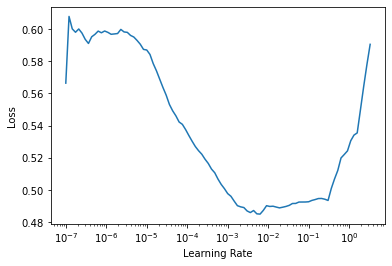

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, lr_max=3e-4)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.validate()

(#1) [0.5206722021102905]

In [ ]:
learn.save('convattn_test2')
# model = ConvAttn(1, conv_dims=[64, 128, 128], num_encoder_layers=8, dim_ff=512, nhead_enc=8)

Path('../models/convattn_test2.pth')

In [ ]:
from step.utils import eval_andi_metrics, validate_andi

In [ ]:
validate_andi(learn.model, dim=2, bs=256)

In [ ]:
x, y = dls.valid.one_batch()

In [ ]:
pred = to_detach(learn.activation(learn.model(x)))

In [ ]:
i = 11
# o = post_process_prediction(pred[i])

pred = pred.squeeze()
# y[i], pred[i]

<matplotlib.legend.Legend>

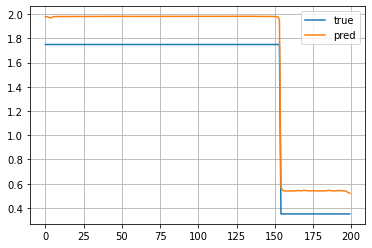

In [ ]:
plt.plot(y[i].cpu(), label="true")
plt.plot(pred[i], label="pred")
plt.grid()
plt.legend()

In [ ]:
err, f1 = eval_andi_metrics(dls, learn.model)
err, f1

### XResNet + Encoder + FNN 

In [ ]:
#| export
@delegates(XResBlocks.__init__)
class XResAttn(Module):
    "Xresnet blocks with attention at the end."
    def __init__(self, dim, n_class=5, conv_blocks=[1, 1], block=ResBlock, block_szs=[64, 128],
                 nhead_enc=1, n_encoder_layers=6, dim_ff=2048, dropout=0.1, pos_enc=True, 
                 linear_layers=[128], activation='relu', norm=True, yrange=(0, 2.05), **kwargs):
        store_attr('dim,n_class')
        self.norm = Normalization(1) if norm else noop
        self.convs = XResBlocks(block, conv_blocks, c_in=dim, block_szs=block_szs, stride=1, **kwargs)
        self.encoder = tfm_encoder(block_szs[-1], nhead_enc, n_encoder_layers, dim_ff, dropout, activation)
        self.pos_enc = PositionalEncoding(block_szs[-1]) if pos_enc else noop
        linear_layers = [block_szs[-1]] + linear_layers + [n_class]
        ps = [dropout]*(len(linear_layers)-1)
        self.linear = Classifier(linear_layers, ps, trp=(2, 1))
        # act is called in forward, activation is called in validation functions.
        self.act, self.activation = _get_acts(n_class, yrange)
        
    def forward(self, x, use_mask=False, src_mask=None, src_key_padding_mask=None):
        x = self.norm(x)
        x = self.convs(x.transpose(2, 1)).transpose(2, 1)
        src = self.pos_enc(x.transpose(1, 0))
        if use_mask and src_mask is None: src_mask = self.get_random_mask(src.shape[0])
        out_enc = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        return self.act(self.linear(out_enc.transpose(1, 0)))
    
    def _reset_parameters(self):
        "Initiate parameters in the transformer model."
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

In [ ]:
dim = 2
dls = get_segmentation_dls(dim=dim, target='y_exp', size=10000)
dls.device = default_device()

In [ ]:
model = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1], block_szs=[64, 128], 
                 n_encoder_layers=6, dim_ff=512, nhead_enc=8, linear_layers=[])
model.to(default_device())
learn = Learner(dls, model, loss_func=L1LossFlat(), model_dir='../models')

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=0.00013182566908653826)

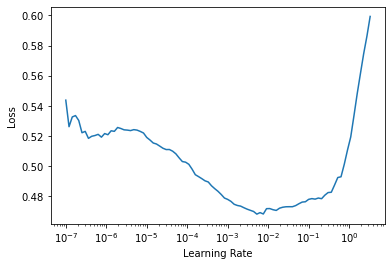

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, lr_max=2e-4)

epoch,train_loss,valid_loss,time
0,0.351831,0.341731,05:52
1,0.317376,0.313373,05:53
2,0.296154,0.291456,05:53
3,0.276105,0.274482,05:53
4,0.265737,0.263980,05:53
5,0.256997,0.253854,05:53
6,0.245702,0.243755,05:53
7,0.243005,0.237430,05:53
8,0.235679,0.235492,05:53
9,0.231861,0.231436,05:53


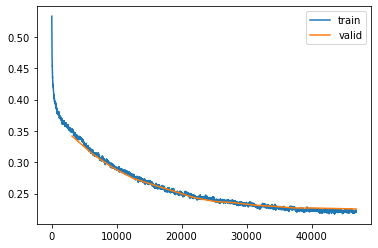

In [ ]:
learn.recorder.plot_loss()

### Unet

In [ ]:
#| export
class AttnDynamicUnet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder, n_out, img_size, ndim=1, num_encoder_layers=6, nhead_enc=8, 
                 dim_ff=1024, p=0.1, act='relu', blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        imsize = img_size
        sizes = model_sizes(encoder, size=imsize)
        sz_chg_idxs = list(reversed(_get_sz_change_idxs(sizes)))
        self.sfs = hook_outputs([encoder[i] for i in sz_chg_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, ndim=ndim, **kwargs),
                                    ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, ndim=ndim, **kwargs)).eval()
        x = middle_conv(x)

        encoder_layer = nn.TransformerEncoderLayer(ni, nhead_enc, dim_ff, p, act)
        encoder_norm = nn.LayerNorm(ni)
        tfm_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)
        transp = Transpose((2, 1))
        x = transp(tfm_encoder(transp(x)))
        
        layers = [encoder, BatchNorm(ni, ndim=ndim), nn.ReLU(), middle_conv, transp, tfm_encoder, transp]

        for i,idx in enumerate(sz_chg_idxs):
            not_final = i!=len(sz_chg_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sz_chg_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], ndim=ndim, final_div=not_final, blur=do_blur, 
                                      self_attention=sa, act_cls=act_cls, init=init, norm_type=norm_type, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-ndim:]: layers.append(PixelShuffleUpsampling(ni, ndim=ndim, act_cls=act_cls, norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls, norm_type=norm_type, ndim=ndim, **kwargs))
        layers += [ConvLayer(ni, n_out, ks=1, act_cls=None, norm_type=norm_type, ndim=ndim, **kwargs)]
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
            
class UnetBlock(Module):
    "A quasi-UNet block, using `GeneralPixelShuffle` upsampling`."
    @delegates(ConvLayer.__init__)
    def __init__(self, up_in_c, x_in_c, hook, ndim=1, final_div=True, blur=False, act_cls=defaults.activation,
                 self_attention=False, init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        self.dim = ndim
        self.hook = hook
        self.shuf = PixelShuffleUpsampling(up_in_c, up_in_c//2, ndim=ndim, blur=blur, act_cls=act_cls, norm_type=norm_type)
        self.bn = BatchNorm(x_in_c, ndim=ndim)
        ni = up_in_c//2 + x_in_c
        nf = ni if final_div else ni//2
        # Beware that using attention like this improved results in initial tests check whether it needs a transpose
#         self.attn = tfm_encoder(ni, n_head=1, n_layers=2, dim_ff=ni, dropout=0.1, activation='relu')
        self.conv1 = ConvLayer(ni, nf, ndim=ndim, act_cls=act_cls, norm_type=norm_type, **kwargs)
        self.conv2 = ConvLayer(nf, nf, ndim=ndim, act_cls=act_cls, norm_type=norm_type,
                               xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = act_cls()
        apply_init(nn.Sequential(self.conv1, self.conv2), init) # Add attention here accordingly

    def forward(self, up_in):
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-self.dim:]
        if ssh != up_out.shape[-self.dim:]:
            up_out = F.interpolate(up_out, s.shape[-self.dim:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))
            
def _get_sz_change_idxs(sizes):
    "Get the indexes of the layers where the size of the activation changes."
    feature_szs = [size[-1] for size in sizes]
    sz_chg_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    return sz_chg_idxs

def model_sizes(m, size=(64,64)):
    "Pass a dummy input through the model `m` to get the various sizes of activations."
    with hook_outputs(m) as hooks:
        _ = dummy_eval(m, size=size)
        return [o.stored.shape for o in hooks]

def in_channels(m):
    "Return the shape of the first weight layer in `m `."
    for l in flatten_model(m):
        if getattr(l, 'weight', None) is not None and l.weight.ndim>=3: #conv1d or 2d
            return l.weight.shape[1]
    raise Exception('No weight layer')
    
def dummy_eval(m, size=(64,64)):
    "Evaluate `m` on a dummy input of a certain `size`"
    ch_in = in_channels(m)
    x = one_param(m).new(1, ch_in, *size).requires_grad_(False).uniform_(-1.,1.)
    with torch.no_grad(): return m.eval()(x)
    
class ResizeToOrig(Module):
    "Merge a shortcut with the module result by adding or concatenating them if `dense=True`."
    def __init__(self, mode='nearest'): self.mode = mode
    def forward(self, x):
        dim = len(x.shape) - 2
        if x.orig.shape[-dim:] != x.shape[-dim:]:
            x = F.interpolate(x, x.orig.shape[-dim:], mode=self.mode)
        return x

class GeneralPixleShuffle(Module):
    "Generic Pixle Shuffle to work with any data dimensionality."
    def __init__(self, upscale_factor): self.scale = upscale_factor
    def forward(self, x):
        in_size = list(x.size())
        dim = len(in_size) - 2
        in_size[1] //= (self.scale**dim)
        out_size = [dim*self.scale for dim in in_size[2:]]
        in_view = x.contiguous().view(*in_size[:2], *(([self.scale]*dim) + in_size[2:]))
        idx = list(range(2, 2+2*dim))
        idx = idx[1::2] + idx[0::2]
        shuffle_out = (in_view.permute(0, 1, *(idx[::-1])).contiguous() if dim > 1 else
                       in_view.permute(0, 1, *idx).contiguous())                    
        return shuffle_out.view(*in_size[:2], *out_size)

class PixelShuffleUpsampling(nn.Sequential):
    "Updample by `scale` from `ni` filters to `nf` using `GeneralPixleShuffle`."
    def __init__(self, ni, nf=None, scale=2, ndim=2, blur=False, norm_type=NormType.Weight, act_cls=defaults.activation):
        super().__init__()
        nf = ifnone(nf, ni)
        layers = [ConvLayer(ni, nf*(scale**ndim), ks=1, ndim=ndim, norm_type=norm_type, act_cls=act_cls, bias_std=0),
                  GeneralPixleShuffle(scale)]
        layers[0][0].weight.data.copy_(icnr_init_general(layers[0][0].weight.data))
        if blur:
            pad = getattr(nn, f"ReplicationPad{int(ndim)}d")
            avg_pool = getattr(nn, f"AvgPool{int(ndim)}d")
            layers += [pad((1, 0)*ndim), avg_pool(2, stride=1)]
        super().__init__(*layers)
        
def icnr_init_general(x, scale=2, init=nn.init.kaiming_normal_):
    "Generic version of `icnr_init`."
    ni, nf, *shape = x.shape
    ni2 = int(ni/scale**len(shape))
    k = init(x.new_zeros([ni2, nf, *shape])).transpose(0, 1)
    k = k.contiguous().view(ni2, nf, -1)
    k = k.repeat(1, 1, scale**len(shape))
    return k.contiguous().view([nf, ni, *shape]).transpose(0, 1)

In [ ]:
#| include: false
from step.data import get_segmentation_dls
from step.utils import post_process_prediction

In [ ]:
#| export
class UnetModel(SequentialEx):
    @delegates(AttnDynamicUnet.__init__)
    def __init__(self, encoder, n_class, img_size, nf=64, linear_layers=[128], p=0.1, y_range=(0, 2.05), **kwargs): 
        norm = Normalization(1)
        unet = AttnDynamicUnet(encoder, nf, img_size, p=p, **kwargs)
        tp = Transpose((2, 1))
        linear_layers = [nf] + linear_layers + [n_class]
        ps = [p]*(len(linear_layers)-1)
        linear = Classifier(linear_layers, ps, trp=(2, 1))
        act, self.activation =  _get_acts(n_class, yrange=y_range)
        
        layers = [norm, tp, unet, tp, linear, act]
        super().__init__(*layers)

In [ ]:
dls = get_segmentation_dls(target='y_exp')
dls.device = default_device()

In [ ]:
encoder = XResBlocks(ResBlock, [1, 2, 1], c_in=1, stem_szs=(32,), block_szs=[64, 128, 256])
umodel = UnetModel(encoder, 1, (200,), num_encoder_layers=4, dim_ff=512, linear_layers=[], y_range=(0, 2.05))
umodel.to(default_device())
ulearn = Learner(dls, umodel, loss_func=L1LossFlat(), model_dir='../models')

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=5.248074739938602e-05)

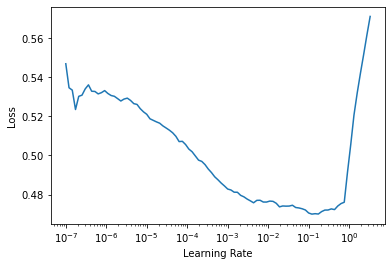

In [ ]:
ulearn.lr_find()

In [ ]:
ulearn.fit_one_cycle(15, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,0.353012,0.344957,00:35
1,0.335089,0.334739,00:35
2,0.332037,0.327504,00:35
3,0.324102,0.323693,00:36
4,0.317840,0.316003,00:36
5,0.312131,0.314038,00:36
6,0.309137,0.310193,00:35
7,0.308097,0.305047,00:35
8,0.303723,0.304123,00:36
9,0.299942,0.302303,00:36


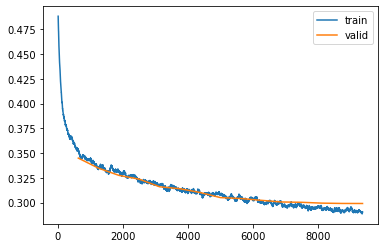

In [ ]:
ulearn.recorder.plot_loss()

In [ ]:
ulearn.validate()

(#1) [0.5628774762153625]

In [ ]:
validate_andi(ulearn.model, dim=2, bs=256)

In [ ]:
x, y = dls.one_batch()

In [ ]:
pred = to_detach(ulearn.model(x).squeeze())

<matplotlib.legend.Legend>

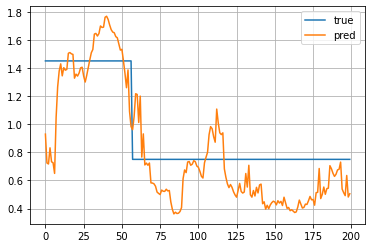

In [ ]:
i = 10
plt.plot(y[i].cpu(), label="true")
plt.plot(pred[i], label="pred")
plt.grid()
plt.legend()

## Export -

In [ ]:
#| include: false
from nbdev.export import notebook2script
notebook2script()

Converted 00_data.ipynb.
Converted 01_models.ipynb.
Converted 02_utils.ipynb.
Converted index.ipynb.
